# Practica 1 - Control Automatico 2020-I 
### Alumno: Bregy Malpartida

Esta es la resolución de la práctica 1 del Curso de Control automático, para su resolución se usó Python junto a la librería [python-control](https://python-control.readthedocs.io/en/0.8.3/), ademas de numpy, matplotlib y sympy.

In [200]:
import numpy as np
import control as ct
from matplotlib import pyplot as plt
import sympy as sp
from IPython.display import display, Math
import array_to_latex as a2l
from scipy import signal

%matplotlib inline
sp.init_printing()
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

## Pregunta 1
Se tiene el siguiente sistema mecánico mostrado en la Figura 1. Considere que el sistema presenta una polea ideal (se desprecia el momento de inercia) y que parte del equilibrio estático, y que presenta los siguientes valores K1=200 N/m, K2=100 N/m, M1=1.5 Kg, M2=2 Kg, B1 =15 N.s/m, B2 =25 N.s/m. Determine lo siguiente:
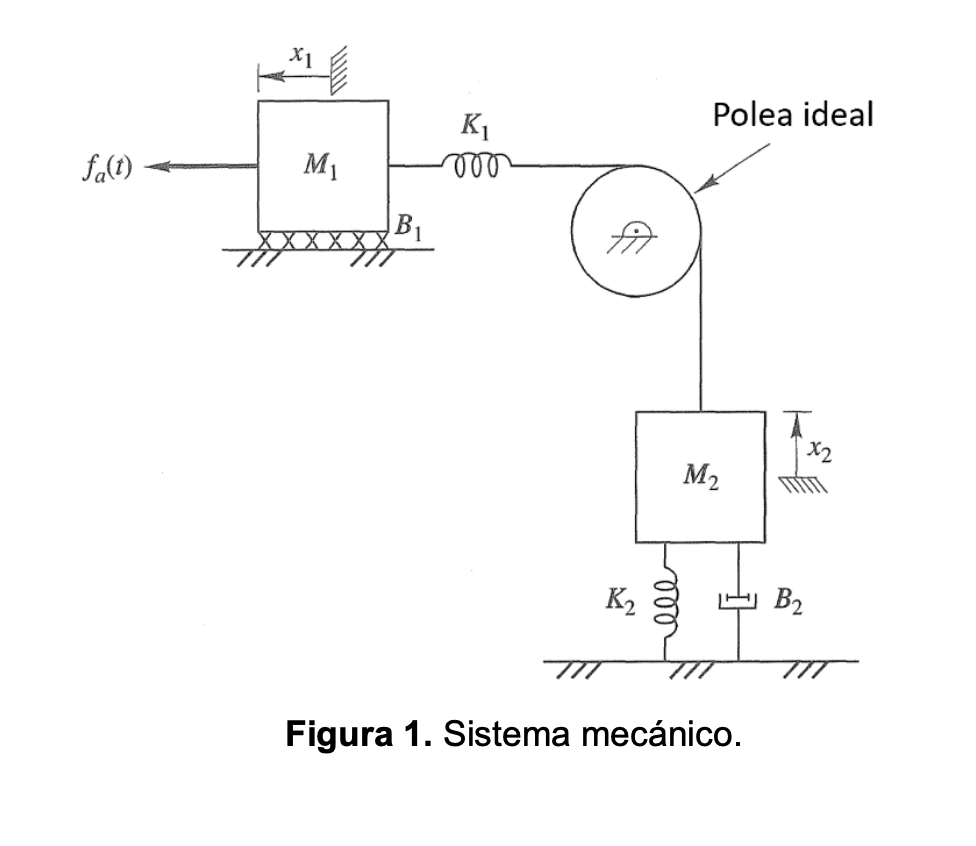

---
### a) Determine el modelo matemático del sistema en la forma canónica controlable. Considere como salida la posición del bloque 1.
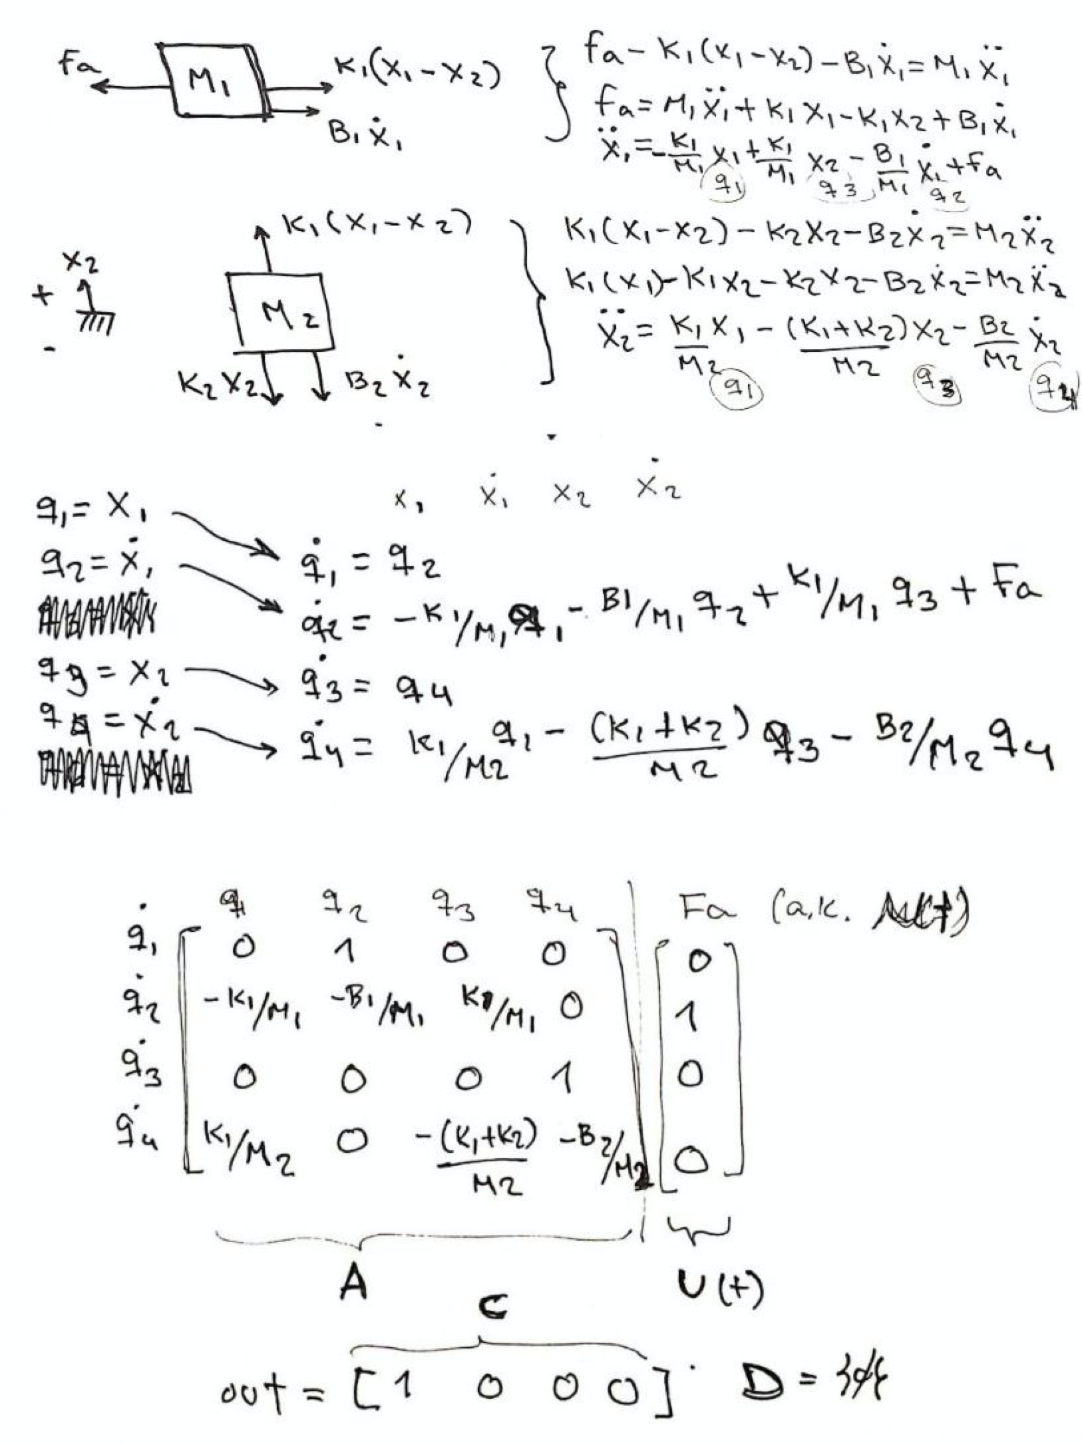

In [1041]:
#  K1=200 N/m, K2=100 N/m, M1=1.5 Kg, M2=2 Kg, B1 =15 N.s/m, B2 =25 N.s/m
K1 = 200
K2 = 100
M1 = 1.5
M2 = 2
B1 = 15
B2 = 25

# Construyendo el espacio de estados en su forma ordinaria
A = np.array([
    [0, 1, 0, 0], 
    [-K1/M1, -B1/M1, K1/M1, 0],
    [0, 0, 0, 1],
    [K1/M2, 0, -(K1+K2)/M2, -B2/M2]
])
B = np.array([[0], [1/M1], [0], [0]])
C = np.array([1, 0, 0, 0])
D = np.array([[0]])

# Extrayendo la función de transferencia en la forma Y(s)/U(s)
sys = ct.StateSpace(A, B, C, D)
tfSys = ct.ss2tf(sys)

tfSys


-1.421e-14 s^3 + 0.6667 s^2 + 8.333 s + 100
-------------------------------------------
s^4 + 22.5 s^3 + 408.3 s^2 + 3167 s + 6667

In [1044]:
tfSys = ct.TransferFunction([0.667, 8.333, 100], [1, 22.5, 408.3, 3167, 6667])
den = np.reshape(tfSys.den, [1, -1])
num = np.reshape(tfSys.num, [1, -1])
tfSys


        0.667 s^2 + 8.333 s + 100
------------------------------------------
s^4 + 22.5 s^3 + 408.3 s^2 + 3167 s + 6667

De la forma canonica controlable (fuente: [Wikipedia](https://www.wikiwand.com/en/State-space_representation))
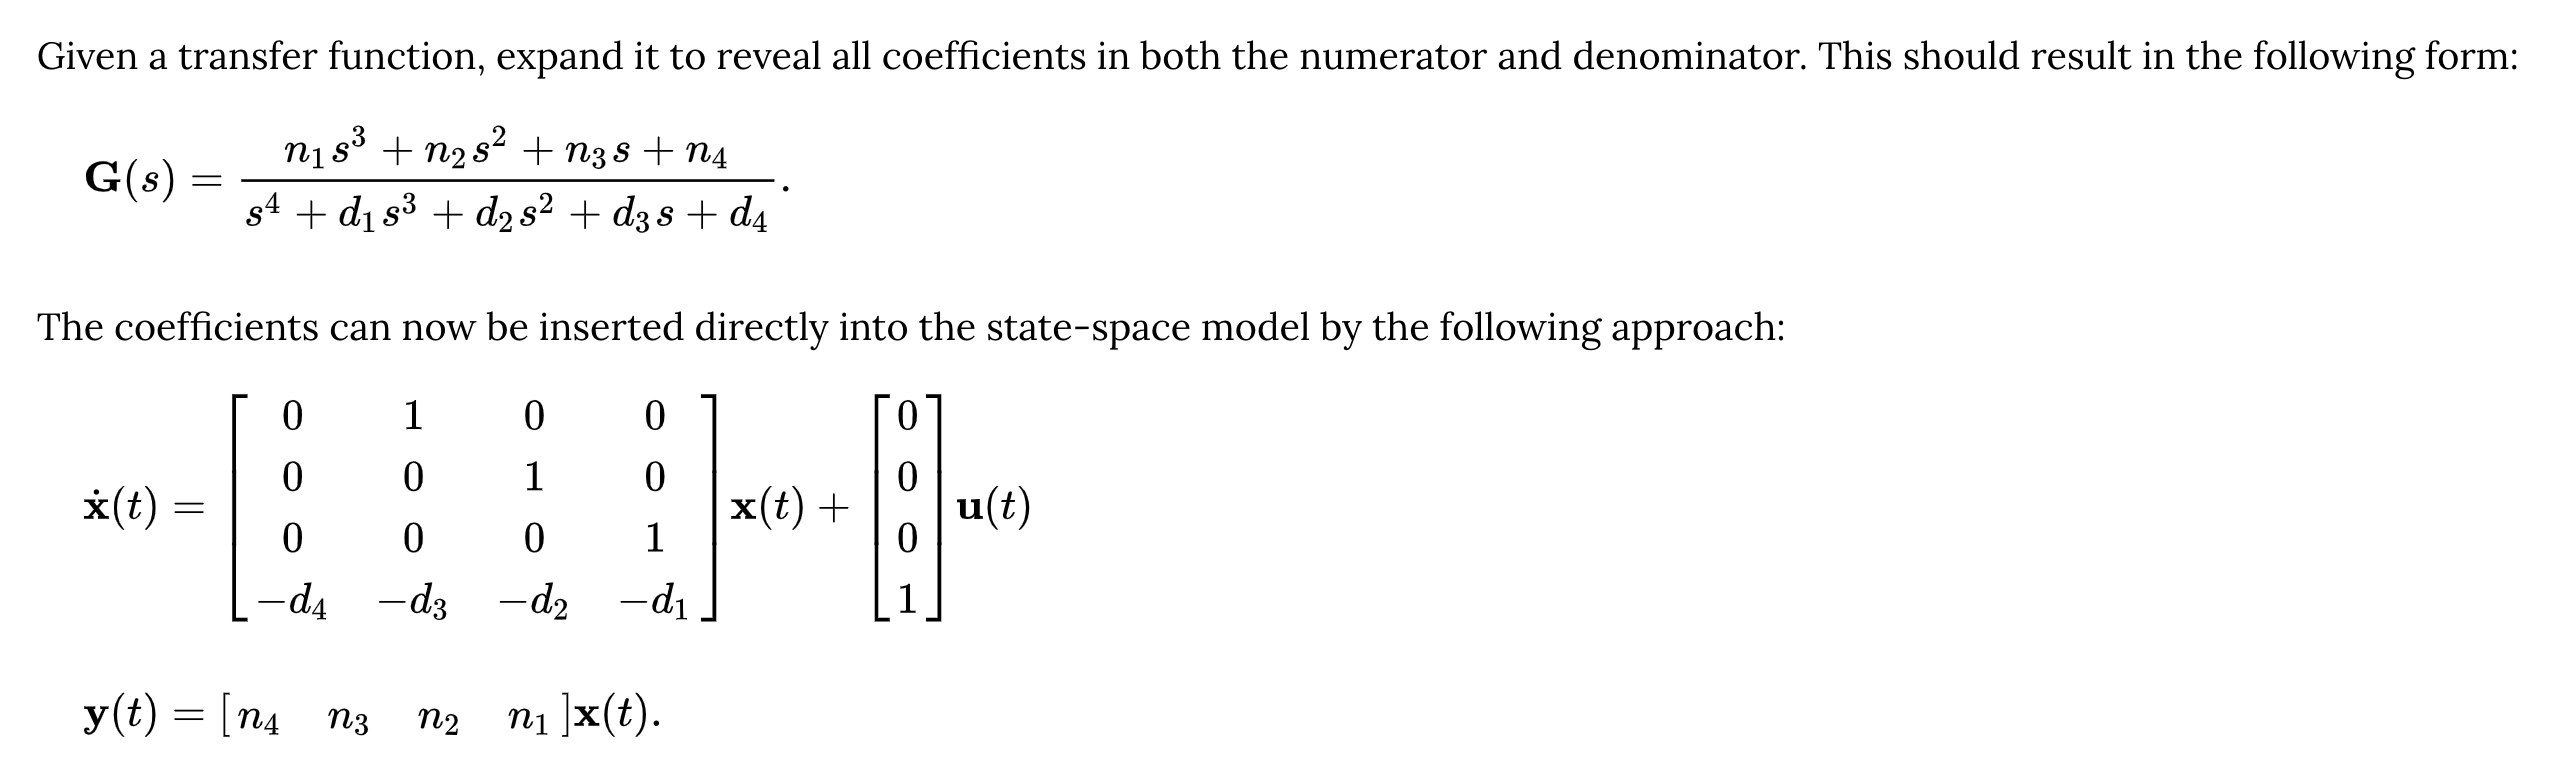

In [1043]:
d = -1 * np.flip(den)[:, :-1]
base = np.concatenate((np.zeros([d.size-1, 1]), np.eye(d.size-1)), axis=1)

# Forma Controlable
Ac = np.concatenate((base, d), axis=0)
Bc = np.concatenate((np.zeros([d.size-1, 1]), [[1]]), axis=0)
Cc = np.concatenate((np.flip(num), np.zeros([1, d.size-num.size])), axis=1)

sysC = ct.StateSpace(Ac, Bc, Cc, 0)

display(Math("A = " + sp.latex(sp.Matrix(sysC.A))))
display(Math("B = " + sp.latex(sp.Matrix(sysC.B))))
display(Math("C = " + sp.latex(sp.Matrix(sysC.C))))
display(Math("D = " + sp.latex(sp.Matrix(sysC.D))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

---
### b) Determine el comportamiento temporal y la estabilidad del sistema realimentado con realimentación unitaria. Justifique su respuesta.

In [1045]:
tfSys


        0.667 s^2 + 8.333 s + 100
------------------------------------------
s^4 + 22.5 s^3 + 408.3 s^2 + 3167 s + 6667

In [1046]:
sysWFeedback = tfSys.feedback(1) # Realimentación unitaria
sysWFeedback


        0.667 s^2 + 8.333 s + 100
----------------------------------------
s^4 + 22.5 s^3 + 409 s^2 + 3175 s + 6767

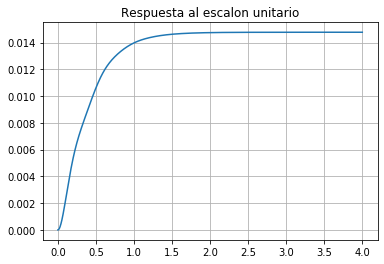

In [1047]:
t = np.linspace(0, 4, 1000)
t, y = ct.step_response(sysWFeedback, t)
plt.grid()
plt.title("Respuesta al escalon unitario")
plt.plot(t, y)

In [1049]:
ct.damp(sysWFeedback, doprint=True);

_____Eigenvalue______ Damping___ Frequency_
    -5.629    +14.98j     0.3518         16
    -5.629    -14.98j     0.3518         16
    -7.893                     1      7.893
    -3.349                     1      3.349


[-5.629+14.976j -5.629-14.976j -7.893 +0.j    -3.349 +0.j   ]


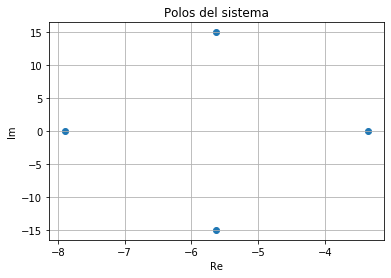

In [1050]:
X = [x.real for x in sysWFeedback.pole()]
Y = [x.imag for x in sysWFeedback.pole()]

print(sysWFeedback.pole())
plt.scatter(X,Y)
plt.xlabel("Re"); plt.ylabel("Im")
plt.title("Polos del sistema")
plt.grid()

#### Comportamiento temporal y estabilidad del sistema
* De la respuesta al escalon del sistema podemos deducir que  tiene una respuesta estable y amortiguada.
* El sistema presenta un par de polos complejos conjugados y dos polos sin componente real.
* Debido a los polos reales negativos, tenemos un damping(z)=1 y por lo tanto podemos decir que el sistema es **críticamente amortiguado**.
* El sistema es estable ya que la componente imaginario de todos sus polos son menores que 0.

---
### c) Determine las constantes de posición, velocidad y aceleración y úselas para determinar los errores de seguimiento al escalón, rampa y parábola unitaria. Verifique estos valores graficando la respuesta del sistema realimentado para estas 3 entradas.

In [1053]:
# Posición: Lim s->0 G(s)
posSys = sysWFeedback * ct.TransferFunction([1], [1])
position = posSys.horner(0) # Horner evalua s en la funcion de transferencia

# Velocidad: Lim s->0 s*G(s)
velSys = sysWFeedback * ct.TransferFunction([1, 0], [1])
velocity = velSys.horner(0)

# Aceleración: Lim s->0 s^2*G(s)
accSys = sysWFeedback * ct.TransferFunction([1, 0, 0], [1])
acceleration = accSys.horner(0)

In [1054]:
print("Constante de position = {}".format(np.real(position)[0,0]))
print("Constante de velocidad = {}".format(np.real(velocity)[0,0]))
print("Constante de aceleración = {}".format(np.real(acceleration)[0,0]))

Constante de position = 0.014777597162701345
Constante de velocidad = 0.0
Constante de aceleración = 0.0


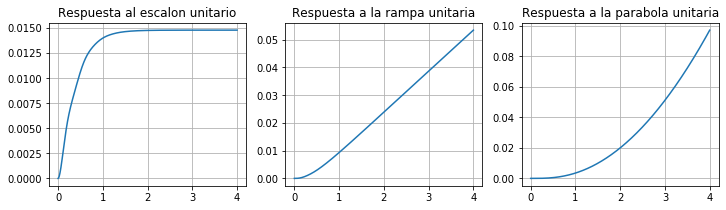

In [1055]:
# Graficando la respuesta del sistema al escalón, rampa y parábola unitaria

t = np.linspace(0, 4, 1000)

uStep = np.ones_like(t) # unitStep
uRamp = t # t
uParabol = 1/2*t**2

plt.figure(figsize=(12, 3))


t, y, x0 = ct.forced_response(sysWFeedback, t, uStep)
plt.subplot(131)
plt.grid()
plt.title("Respuesta al escalon unitario")
plt.plot(t, y)

t, y, x0 = ct.forced_response(sysWFeedback, t, uRamp)
plt.subplot(132)
plt.grid()
plt.title("Respuesta a la rampa unitaria")
plt.plot(t, y)

t, y, x0 = ct.forced_response(sysWFeedback, t, uParabol)
plt.subplot(133)
plt.grid()
plt.title("Respuesta a la parabola unitaria")
plt.plot(t, y)

---
### d) Usando el criterio de Routh-Hurwitz diseñe el siguiente sistema controlado.
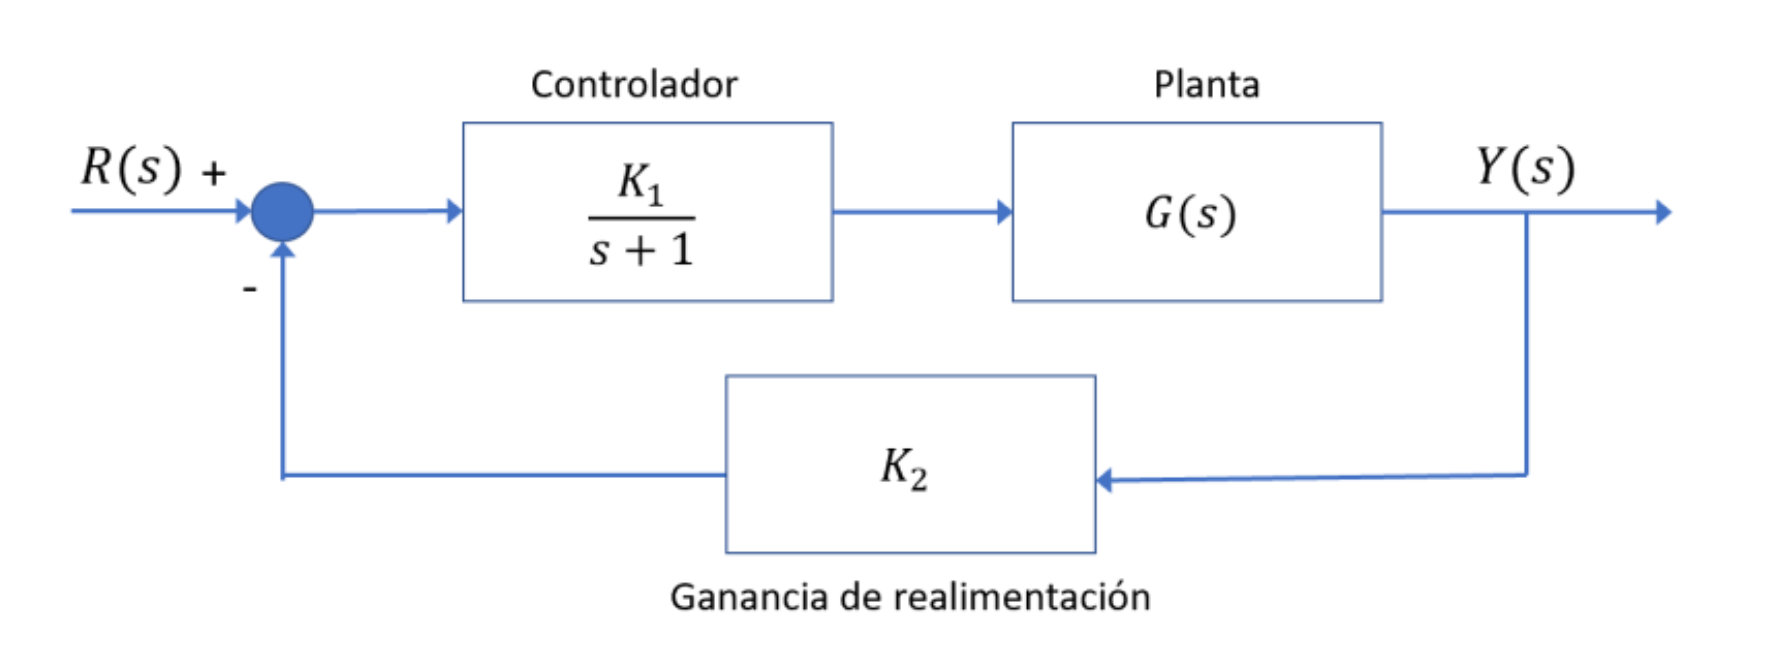

In [1056]:
sysWFeedback


        0.667 s^2 + 8.333 s + 100
----------------------------------------
s^4 + 22.5 s^3 + 409 s^2 + 3175 s + 6767

In [1057]:
s, K1, K2 = sp.var("s K1 K2")

Gs = (0.6667*s**2 + 8.333*s + 100)/(s**4 + 22.5*s**3 + 409*s**2 + 3175*s + 6767)
C = K1/(s+1)

YsRs = Gs*C/(1 + K2*Gs*C)
YsRs = sp.simplify(YsRs)

display(Math("G(s)="+sp.latex(YsRs)))

gDen = sp.Poly(sp.expand(sp.denom(YsRs)), s)

display(Math("Denominador=" + sp.latex(gDen)))

coeffs = gDen.all_coeffs()
display(Math("Coeficientes=" + sp.latex(coeffs)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [1058]:
def hurwitzMatrix(coeffs):
    n = len(coeffs) - 1
    off = len(coeffs) - sp.ceiling(len(coeffs)/2)
    isEven = len(coeffs) % 2 == 0
    h = sp.Matrix(np.zeros((n,n)))
    for i in range(0, n):
        if i%2 != 0:
            left = np.zeros((1, int(sp.floor((i+1)/2) - 1)))
            right = np.zeros((1, off  - ((sp.floor((i+1)/2)))))
            data = np.array([[coeffs[j] for j in range(0, len(coeffs), 2)]])
            row = np.concatenate((left, data, right), axis=1)
            h[i, :] = row 
        else:
            left = np.zeros((1, int(sp.floor(i/2))))
            right = np.zeros((1, int(off - sp.floor(i/2 + 1)) + (0 if isEven else 1)))
            data = np.array([[coeffs[j] for j in range(1, len(coeffs), 2)]])
            row = np.concatenate((left, data, right), axis=1)
            h[i, :] = row 
            
    return h

In [1059]:
hMatrix = hurwitzMatrix(coeffs)
hMatrix

⎡23.5  0.6667⋅K₁⋅K₂ + 3584.0  100.0⋅K₁⋅K₂ + 6767.0            0.0             
⎢                                                                             
⎢1.0           431.5          8.333⋅K₁⋅K₂ + 9942.0            0.0             
⎢                                                                             
⎢0.0           23.5           0.6667⋅K₁⋅K₂ + 3584.0  100.0⋅K₁⋅K₂ + 6767.0     
⎢                                                                             
⎢0.0            1.0                   431.5          8.333⋅K₁⋅K₂ + 9942.0     
⎢                                                                             
⎣0.0            0.0                   23.5           0.6667⋅K₁⋅K₂ + 3584.0  10

      0.0         ⎤
                  ⎥
      0.0         ⎥
                  ⎥
      0.0         ⎥
                  ⎥
      0.0         ⎥
                  ⎥
0.0⋅K₁⋅K₂ + 6767.0⎦

Según el criterio de Hurwitz, con la matriz de hurwitz ya podemos calcular los diferentes minors de la matriz, el criterio indica que para que el polinomio (y por tanto el sistema) sea estable se necesita que cada uno de los minors principales de la matriz sean mayores que 0.

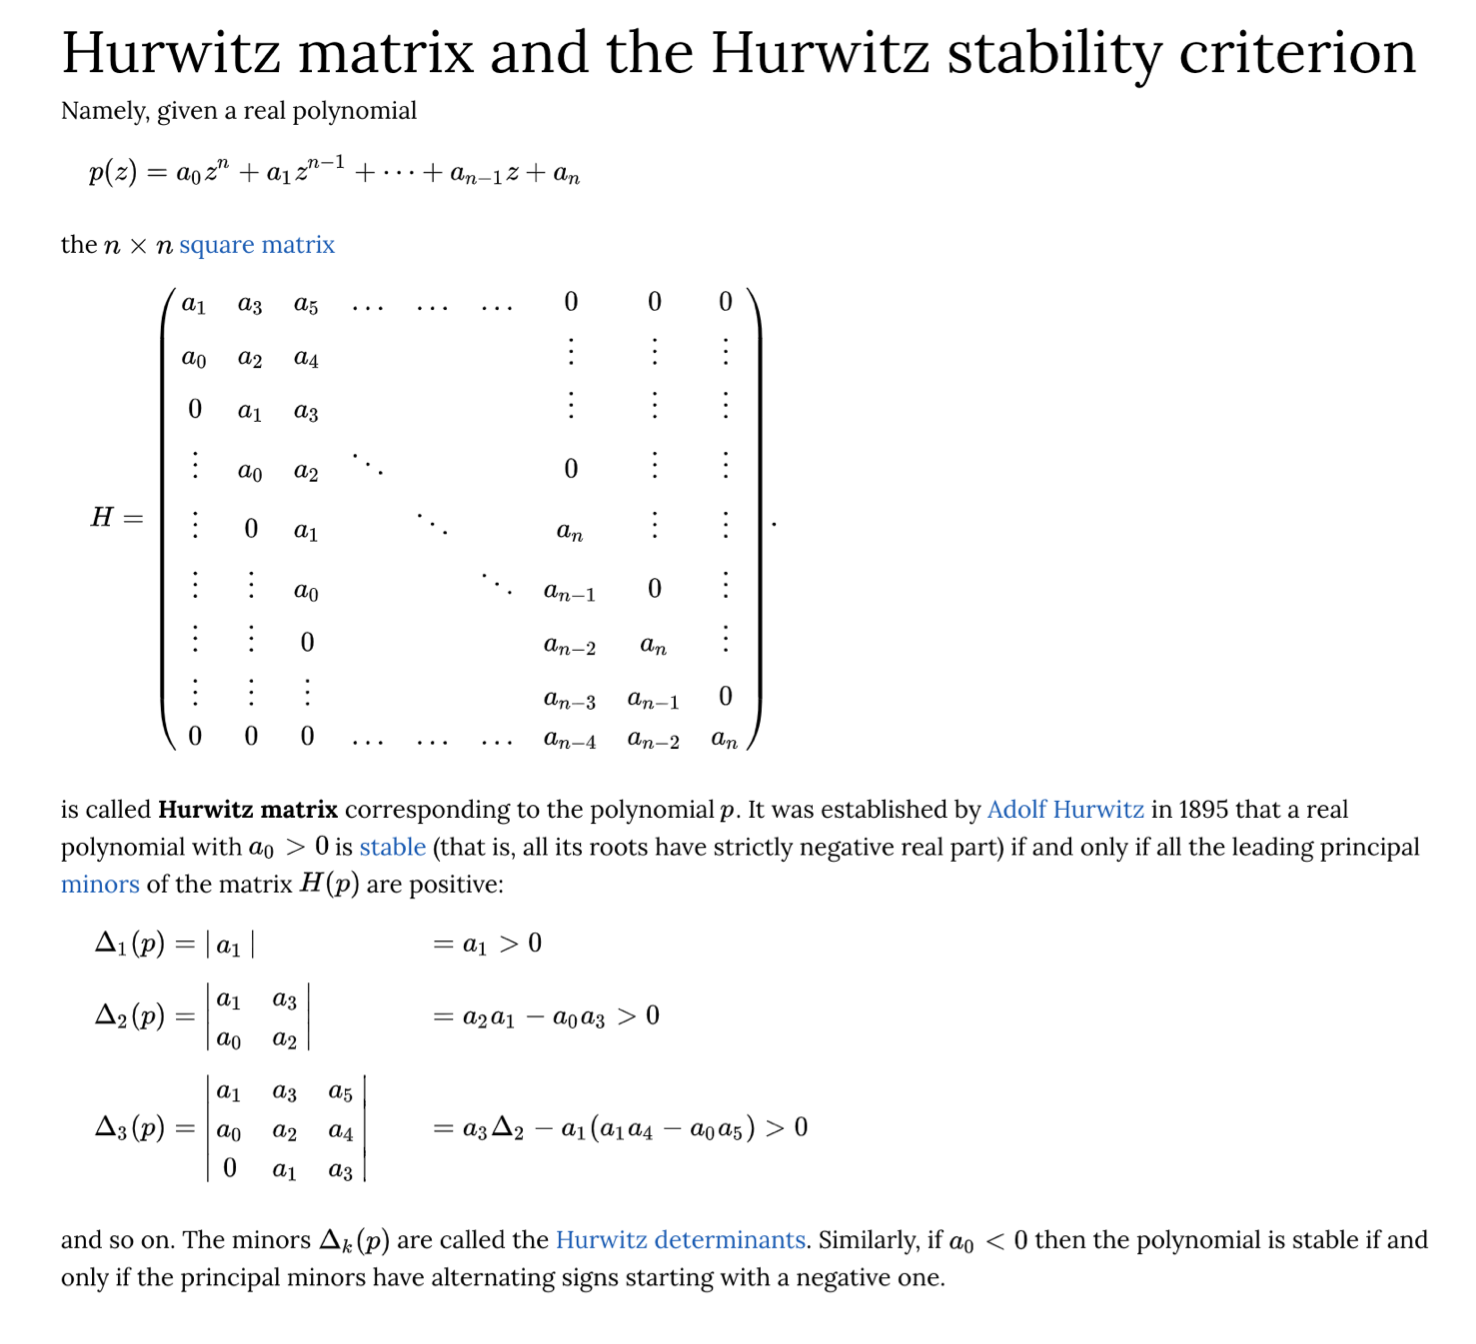

Para comprobar su estabilidad usaré los dos primeros polinomios de los determinates de Hurwitz.

In [1060]:
for i in range(2, 4): # Det2 y Det3 (dos inecuaciones dos incognitas)
    display(Math(sp.latex(sp.det(hMatrix[0:i, 0:i])>0)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

De la primera desigualdad se deduce que:
$$ K_1K_2 < 6556.25 $$

Asumiendo $K_1 = 100$,
replazando en el siguiente polinomio:

$$ 4782.48 \cdot 100 \cdot K_2 - 8202496(0.000233 \cdot 100 \cdot K_2 +1)^2 + 16900323.5  > 0$$
$$ −4453.05𝐾_2^2+96001.6864𝐾_2+8697827.52 > 0$$
$$(K_2+67.042)(K_2-60.96) > 0$$

Entonces el valor de $K_2$ deberá estar en el rango de -34 y 56, finalmente
$$ K_1 = 100 $$
$$ K_2 = 50 $$

Finalmente el control del sistema tendrá la forma $\frac{K_1}{s+1} = \frac{100}{s+1}$ y por otro lado, la ganancia de retroalimentación será igual a $K_2 = 50$

---
### e) Determine la gráfica de la sensibilidad del sistema diseñado en (d) y explique los resultados obtenidos.

$$ S(s) = \frac{1}{1 + H(s)K(s)P(s)} $$

donde H(s) es la ganancia del feedback, P(s) la planta y K(s) la función del controlador.

In [1221]:
plant = sysWFeedback
controller = ct.TransferFunction([100], [1, 1])
gain = 50

sensitivity = 1/(1+controller*plant*gain)
sensitivity = sensitivity.minreal()
sensitivity


     s^5 + 23.5 s^4 + 431.5 s^3 + 3584 s^2 + 9942 s + 6767
---------------------------------------------------------------
s^5 + 23.5 s^4 + 431.5 s^3 + 6919 s^2 + 5.161e+04 s + 5.068e+05

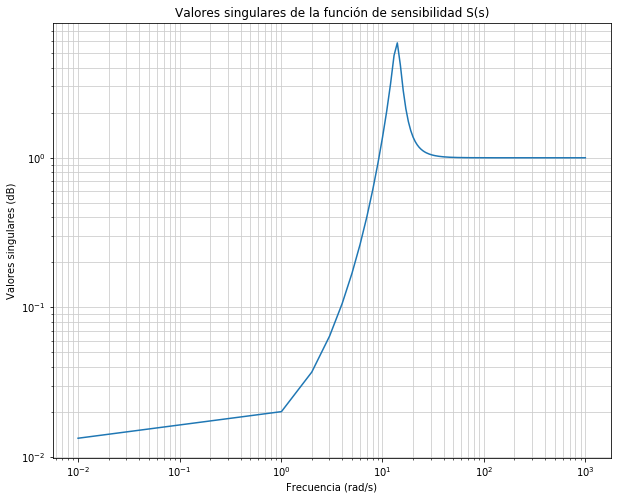

In [1222]:
w = np.linspace(0.01, 1000, 1000)
mag, phase, w = ct.bode(sensitivity, w, Plot=False)
plt.figure(figsize=(10, 8))
plt.title("Valores singulares de la función de sensibilidad S(s)")
plt.ylabel("Valores singulares (dB)")
plt.xlabel("Frecuencia (rad/s)")
plt.loglog(w, mag)
plt.grid(which="both", ls="-", color='0.8')

In [1225]:
10**(5.86/20)

* De la gráfica de la función de sensibilidad del sistema, el pico de sensibilidad nominal es de al rededor de $5.86\ dB = 10^{5.86/20} = 1.96$.
* De la gráfica de la función, sabes que el pico de sensibilidad nominal se encuentra en $14.024\ rad/s$
* De la gráfica de la sensibilidad podemos decir que es necesario ajustar el sistema con un filtro de frecuencias bajas medias (al rededor de 14.024rad/s) ya que ahí, la ganancia del sistema se ve incrementada 5.86dB.

---
## Pregunta 2
Se tiene el siguiente diagrama de bloques mostrado en la Figura 2.
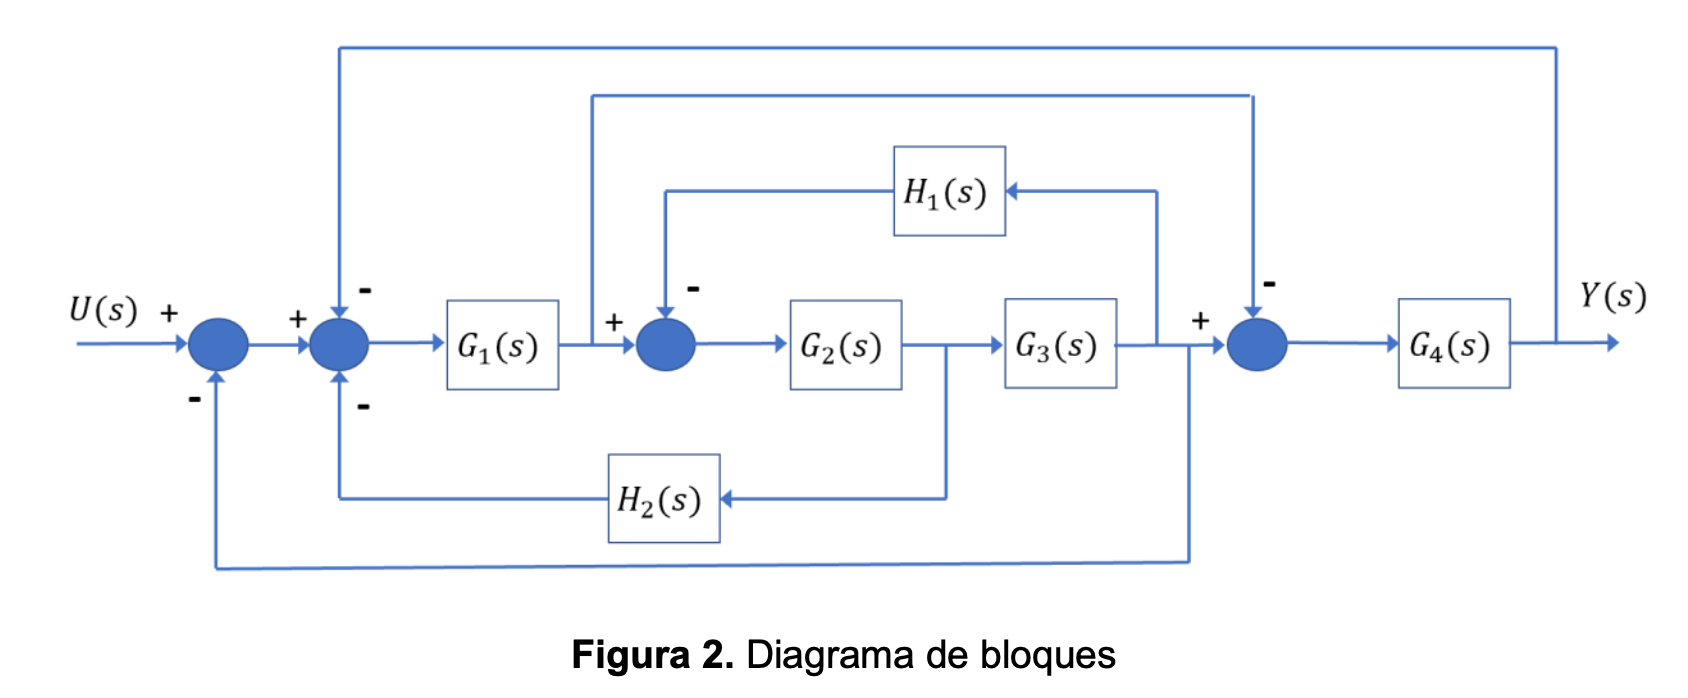

---
### a) Muestre los procedimientos de reducción del sistema y obtenga la función de transferencia Y(s)/U(s).

Para resolver este problema usando la fórmula de reducción de Mason, yo prefiero usar su versión matricial alternativa ya que es más directa y me permite computarizar los cálculos de las determinantes individuales de los paths y los loops. Referencia a la forma matricial de Mason [aquí](https://www.wikiwand.com/en/Mason%27s_gain_formula)
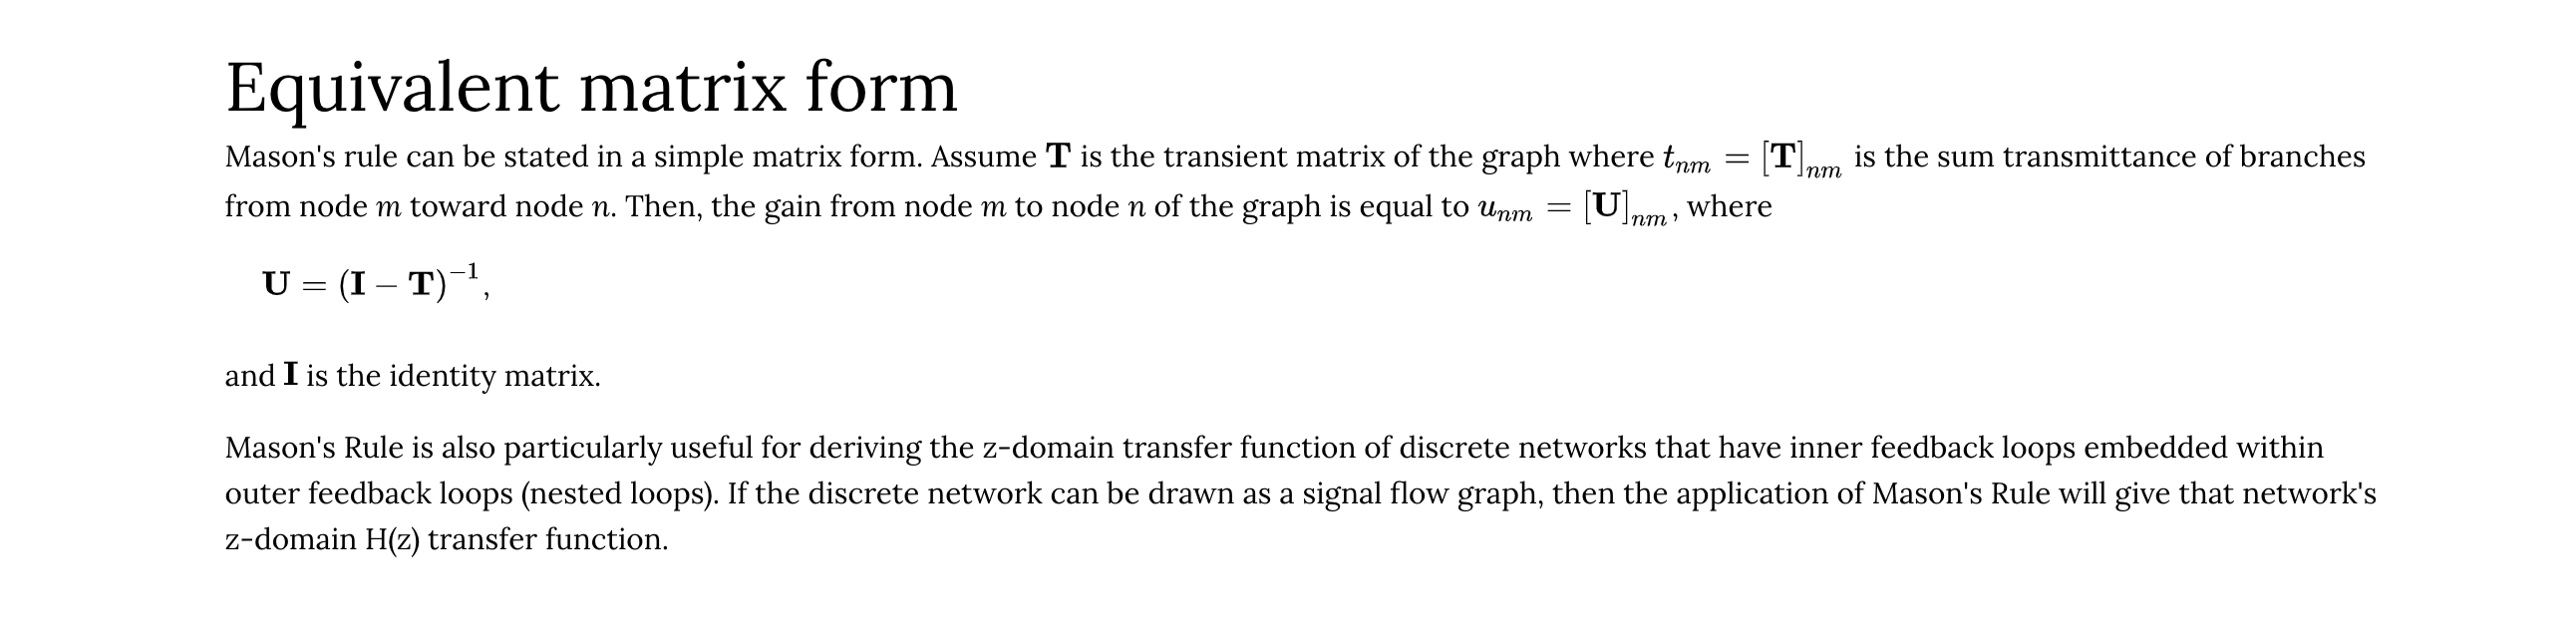

**T** es la matriz trascendente del grafo de flujos del sistema. Para poder conseguir esa matriz tengo que representar en un diagrama de flujos dicho sistema.

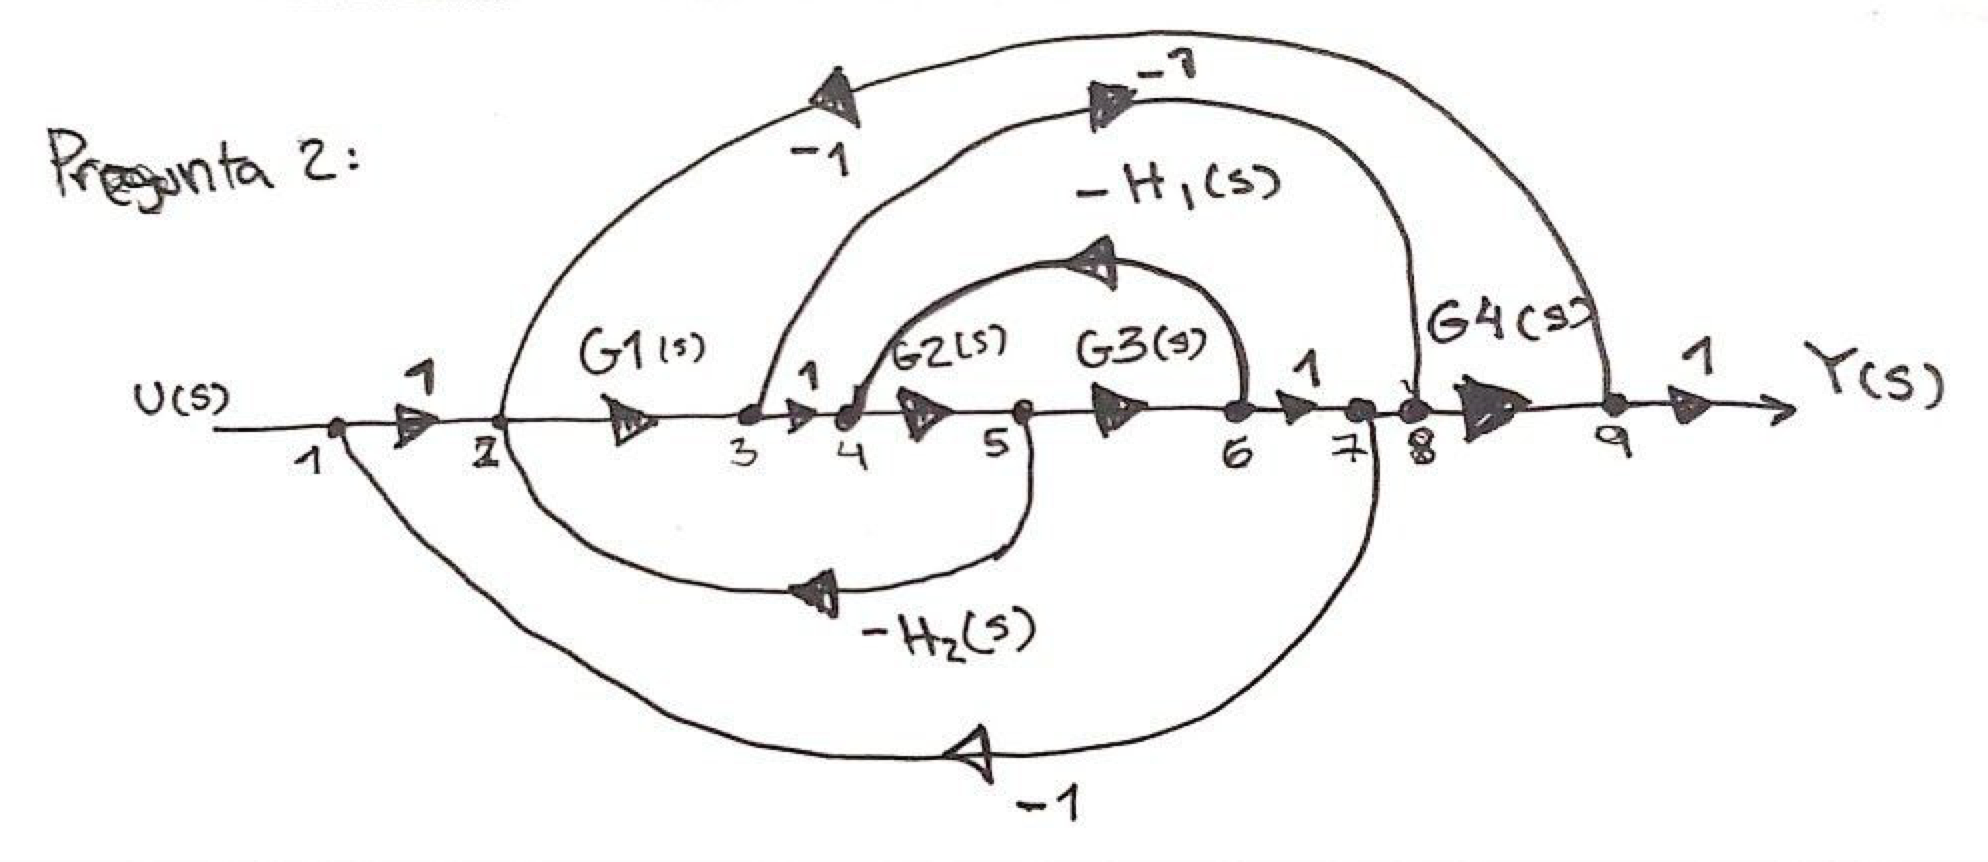

1 → 2:  1  \
2 → 3:  G1 \
3 → 4:  1  \
4 → 5:  G2 \
5 → 6:  G3 \
6 → 7:  1  \
7 → 8:  1  \
8 → 9:  G4 \
9 → 2:  -1 \
3 → 8:  -1 \
7 → 1:  -1 \
6 → 4:  -H1\
5 → 2:  -H2

In [1167]:
# Construyendo la matriz de adyacencia:
G1, G2, G3, G4, H1, H2 = sp.var("G1 G2 G3 G4 H1 H2")

T = sp.Matrix(np.zeros((9, 9)))
T[0,1] = 1
T[1,2] = G1
T[2,3] = 1
T[3,4] = G2
T[4,5] = G3
T[5,6] = 1
T[6,7] = 1
T[7,8] = G4
T[8,1] = -1
T[2,7] = -1
T[6,0] = -1
T[5,3] = -H1
T[4,1] = -H2
display(Math(sp.latex(T)))

# U = (I-T)^-1
U = sp.Matrix(np.eye(9)) - T
U = U.inv()

<IPython.core.display.Math object>

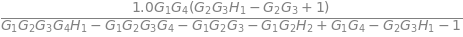

In [1169]:
s2 = sp.simplify(U[0, 8])
s2

Finalmente, la función de transferencia obtenida con la reducción de Mason es:

$$\frac{Y(s)}{U(s)}=\frac{ G_{1} G_{4} \left(G_{2} G_{3} H_{1} - G_{2} G_{3} + 1\right)}{G_{1} G_{2} G_{3} G_{4} H_{1} - G_{1} G_{2} G_{3} G_{4} - G_{1} G_{2} G_{3} - G_{1} G_{2} H_{2} + G_{1} G_{4} - G_{2} G_{3} H_{1} - 1} $$

---
### b) Considere que las funciones de transferencias G1=G2=G3=G4=1/(s+2), H1(s)=2, H2(s)=1.5. Realimente el sistema obtenido en (a) y determine el comportamiento temporal y la estabilidad del sistema con realimentación unitaria usando el criterio de Routh-Hurwitz.

In [1170]:
sys2s = s2.subs({G1:1/(s+2), G2:1/(s+2), G3:1/(s+2), G4:1/(s+2), H1:2, H2:1.5})
sys2s = sp.simplify(sys2s)
sys2s = sp.cancel(sys2s)

Por lo tanto, la función de transferencia del sistema es:

$$ \frac{Y(s)}{U(s)} = -\frac{s^2+4s+5}{s^4+8s^3+26.5s^2+43s+27}$$

Realimentando el sistema

In [1129]:
sys2 = ct.TransferFunction([-1, -4, -5], [1, 8, 26.5, 43, 27])
sys2WFeedback = ct.feedback(sys2, 1) # Sistema realimentado

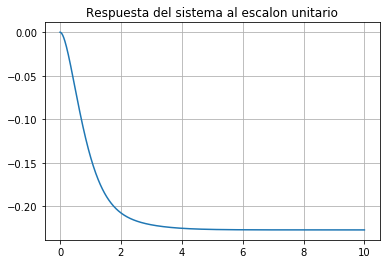

In [1131]:
# Comportamiento temporal
t = np.linspace(0, 10, 1000)
t, y = ct.step_response(sys2WFeedback, t)
plt.plot(t,y)
plt.title("Respuesta del sistema al escalon unitario")
plt.grid()

Calculando la matriz de Hurwitz para aplicar el criterio de Routh-Hurwitz

In [1142]:
hSys2 = hurwitzMatrix(sys2.den[0][0]) # Matriz de Hurwitz del denomindor de la función de transferencia
hSys2

⎡8.0  43.0  0.0   0.0 ⎤
⎢                     ⎥
⎢1.0  26.5  27.0  0.0 ⎥
⎢                     ⎥
⎢0.0  8.0   43.0  0.0 ⎥
⎢                     ⎥
⎣0.0  1.0   26.5  27.0⎦

In [1156]:
for i in range(1, hSys2.shape[0]+1):
    display(Math("Det("+sp.latex(hSys2[0:i, 0:i])+") > 0"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [1157]:
[sp.det(hSys2[0:i,0:i]) for i in range(1, hSys2.shape[0]+1)]

Como se puede apreciar, cada una de las determinantes de hurwitz es mayor a 0, por lo tanto, se puede decir que según el criterio de estabilidad de Routh-Hurwitz, **el sistema es estable**.

---
### c) Según sus polos subamortiguados más cercanos al eje imaginario (polos subamortiguados más lentos), determine analíticamente el porcentaje de sobreseñal, tiempo de establecimiento al 2% del error y el error en estado estable. Compare estos resultados con los obtenidos usando la función Step. Qué puede concluir de los resultados obtenidos de forma analítica y de la gráfica al escalón del sistema realimentado.

In [1174]:
sys2WFeedback


          -s^2 - 4 s - 5
----------------------------------
s^4 + 8 s^3 + 25.5 s^2 + 39 s + 22

[-3.076+0.j    -1.846+1.548j -1.846-1.548j -1.232+0.j   ]


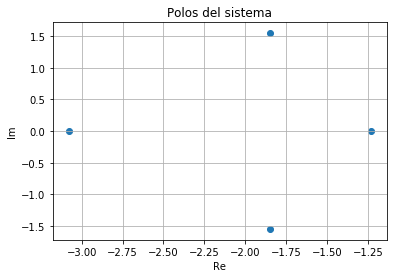

In [1185]:
X = [x.real for x in sys2WFeedback.pole()]
Y = [x.imag for x in sys2WFeedback.pole()]

print(sys2WFeedback.pole())
plt.scatter(X, Y)
plt.xlabel("Re"); plt.ylabel("Im")
plt.title("Polos del sistema")
plt.grid()

In [1189]:
ct.damp(sys2WFeedback, doprint=True);

_____Eigenvalue______ Damping___ Frequency_
    -3.076                     1      3.076
    -1.846    +1.548j     0.7662      2.409
    -1.846    -1.548j     0.7662      2.409
    -1.232                     1      1.232


Los polos complejos conjugados tienen $z=0.76662$ y $w=2.409$

Ademas, se sabe:

$$ \%PO = e^{-\frac{z\pi}{\sqrt{1-z^2}}}\cdot100 $$

$$ Ts(2\%) = \frac{4}{zw} $$ 

In [1200]:
w = 2.409
z = 0.7662
po = np.exp(-(z*np.pi)/(np.sqrt(1-z**2)))*100
ts = 4/(z*w)

display(Math("$\%PO = {:.2f}".format(po)))
display(Math("$T_s(2\%) = {:.2f}".format(ts)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

El porcentaje de overshoot es de alrededor de 2.36% y el tiempo de establecimiento cerca a 2.16 segundos

Se puede concluir
* El tiempo de establecimiento es muy cercano al obtenido al graficar la respuesta al escalon.
* El porcentaje de overshoot (de ~$2\%$) no se evidencia en la gráfica, esto puede deberse a que ese overshoot solo es causado por los polos sub-amortiguados y el sistema tiene, además, 2 polos reales negativos que hacen que el sistema tenga un comportamiento criticamente amortiguado.

---
### d) Muestre la gráfica de la sensibilidad del sistema realimentado y comente, según la gráfica obtenida, si el sistema presenta un comportamiento adecuado con respecto al seguimiento de la trayectoria.

In [1201]:
sys2WFeedback


          -s^2 - 4 s - 5
----------------------------------
s^4 + 8 s^3 + 25.5 s^2 + 39 s + 22

In [1204]:
sensitivity = 1/(1+sys2WFeedback)
sensitivity = sensitivity.minreal()
sensitivity


s^4 + 8 s^3 + 25.5 s^2 + 39 s + 22
----------------------------------
s^4 + 8 s^3 + 24.5 s^2 + 35 s + 17

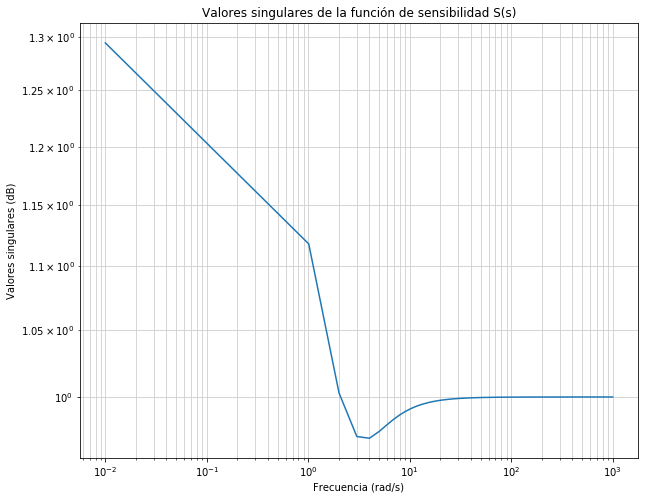

In [1207]:
w = np.linspace(0.01, 1000, 1000)
mag, phase, w = ct.bode(sensitivity, w, Plot=False)
plt.figure(figsize=(10, 8))
plt.title("Valores singulares de la función de sensibilidad S(s)")
plt.ylabel("Valores singulares (dB)")
plt.xlabel("Frecuencia (rad/s)")
plt.loglog(w, mag)
plt.grid(which="both", ls="-", color='0.8')

* La verdad es que a primera vista me desconsierta la gráfica, luego, recordando que el sistema tiene una ganancia de -1,  y que es probable que todo es "flipped" en y. 

*  Entonces, para que el sistema presente un adecuado comportamiento al seguimiento de la trayectoria este tiene que se capaz de reaccionar adecuadamente a todos los rangos de frecuencias (bajas, medias, altas).

* De la gráfica de sensibilidad se puede ver que para una frecuencia baja ($4\ rad/s$) la ganancia del sistema aumenta en $0.97\ dB = 10^{0.97/20} = 1.118$, esto nos indica que el sistema realmente cambiará su amplitud relativamente poco.

* **En conclusión**, yo considero que el sistema **sí** tiene un comportamiento adecuado al seguimiento de la trayectoria